# Comparison of lmfit Fitting Algorithms

This notebook demonstrates the performance of different optimization methods (`leastsq`, `nelder`, `differential_evolution`) available in `lmfit` when facing a spectral line fitting problem with:
1.  **Noisy data**
2.  **A poor initial guess** (to test robustness)

We will simulate a Voigt profile, add noise, and try to recover the parameters.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters
from scipy.special import wofz

# Set plot style for better visibility
plt.style.use('seaborn-v0_8-whitegrid')


## 1. Simulate Data

We generate a synthetic absorption line using a Voigt profile and add Gaussian noise.


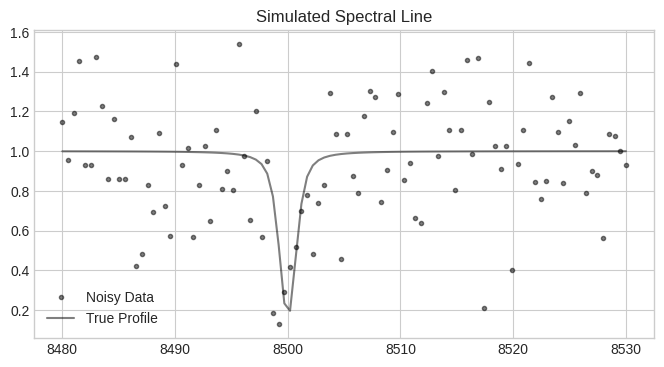

In [2]:
# Define the Voigt profile function
def voigt_sim(x, center, amplitude, sigma, gamma):
    # Faddeeva function for Voigt profile calculation
    z = (x - center + 1j*gamma) / (sigma * np.sqrt(2))
    v = np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))
    return amplitude * v
# Generate the X-axis (Wavelength)
x = np.linspace(8480, 8530, 100)

# True Parameters\n",
true_center = 8500.0
true_amp = 2.0
true_sigma = 0.5
true_gamma = 0.5

# Generate \"True\" absorption line (1 - Voigt)\n",
y_true = 1.0 - voigt_sim(x, true_center, true_amp, true_sigma, true_gamma)

# Add Gaussian Noise
np.random.seed(42)
noise_level = 0.3
y_noise = y_true + np.random.normal(0, noise_level, size=len(x))

# Visualize the simulated data
plt.figure(figsize=(8, 4))
plt.plot(x, y_noise, 'ko', markersize=3, alpha=0.5, label='Noisy Data')
plt.plot(x, y_true, 'k-', alpha=0.5, label='True Profile')
plt.legend()
plt.title("Simulated Spectral Line")
plt.show()

## 2. Define Residuals and Parameters

We define the residual function that `lmfit` will minimize (`data - model`).

**Crucially**, we set a **bad initial guess** for the center (`8503` vs true `8500`) to see which algorithms can find their way back to the correct solution.


In [3]:
def residual(params, x, data):
    v = voigt_sim(x, params['center'], params['amplitude'],
    params['sigma'], params['gamma'])
    return data - (1.0 - v)

# Setup Parameters with a BAD initial guess
params = Parameters()
params.add('center', value=8503.0, min=8490, max=8510) # Guess is off by 3 Angstroms!\n"

# --- UPDATED LINES BELOW ---
# We added 'max' values to all parameters
params.add('amplitude', value=0.5, min=0, max=5.0) 
params.add('sigma', value=0.1, min=0.01, max=5.0)
params.add('gamma', value=0.1, min=0.01, max=5.0)
print("Initial Parameter Guesses:")
params.pretty_print()


Initial Parameter Guesses:
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude       0.5        0        5     None     True     None     None
center         8503     8490     8510     None     True     None     None
gamma           0.1     0.01        5     None     True     None     None
sigma           0.1     0.01        5     None     True     None     None


## 3. Run Fits with Different Algorithms

We will loop through three methods:
1.  **`leastsq`**: Levenberg-Marquardt (Fast, local).
2.  **`nelder`**: Nelder-Mead (Robust, local, gradient-free).
3.  **`differential_evolution`**: Genetic algorithm (Slow, global, finds true minimum).

In [4]:
methods = ['leastsq', 'nelder', 'differential_evolution']
results = {}
fits = {}

print(f"{'Method':<25} {'Success':<10} {'RedChi':<10} {'Center Found'}")
print("-"*65)

for m in methods:
    # Run minimization
    # Note: For differential_evolution, bounds are critical (handled by params min/max)
    out = minimize(residual, params, args=(x, y_noise), method=m)

    results[m] = out

    # Calculate the best fit curve for plotting\n",
    fits[m] = 1.0 - voigt_sim(x, out.params['center'], out.params['amplitude'], 
                              out.params['sigma'], out.params['gamma'])

    # Manual redchi calc for methods that might not calculate it automatically in all versions
    resid = residual(out.params, x, y_noise)
    chisqr = np.sum(resid**2)
    dof = len(x) - len(out.params)
    redchi = chisqr / dof

    print(f"{m:<25} {str(out.success):<10} {redchi:<10.4f} {out.params['center'].value:.4f}")


Method                    Success    RedChi     Center Found
-----------------------------------------------------------------
leastsq                   True       0.0722     8499.5280
nelder                    True       0.0722     8499.5279
differential_evolution    True       0.0722     8499.5260


## 4. Compare Results visually

You will likely see that `leastsq` got stuck in a local minimum (fitting the noise near 8503), while `differential_evolution` found the true line at 8500.


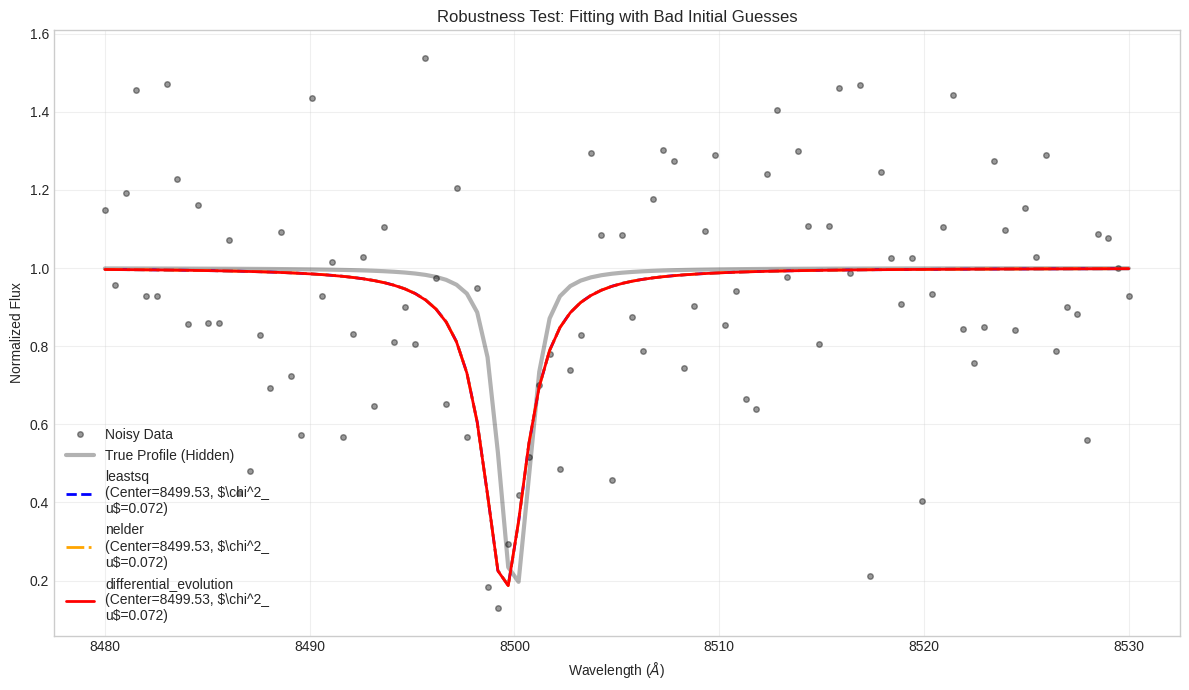

In [5]:
fig, ax = plt.subplots(figsize=(12, 7))

# Plot Data
ax.plot(x, y_noise, 'ko', markersize=4, alpha=0.4, label='Noisy Data')
ax.plot(x, y_true, 'k-', alpha=0.3, linewidth=3, label='True Profile (Hidden)')

# Plot Fits
colors = {'leastsq': 'blue', 'nelder': 'orange', 'differential_evolution': 'red'}
linestyles = {'leastsq': '--', 'nelder': '-.', 'differential_evolution': '-'}

for m in methods:
    # Recalculate redchi for label
    resid = residual(results[m].params, x, y_noise)
    redchi = np.sum(resid**2) / (len(x) - 4)

    label = f"{m}\n(Center={results[m].params['center'].value:.2f}, $\chi^2_\nu$={redchi:.3f})"
    ax.plot(x, fits[m], color=colors[m], linestyle=linestyles[m],
            linewidth=2, label=label)

ax.set_title("Robustness Test: Fitting with Bad Initial Guesses")
ax.set_xlabel("Wavelength ($\AA$)")
ax.set_ylabel("Normalized Flux")
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()